**This notebook is an exercise in the [Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/pipelines).**

---


# pipleline

- clean up your modeling code
- 데이터 전처리나 모델링 코드를 조직적으로 구성할 수 있게 해줌

- benefits

1) Cleaner Code

2) Fewer bugs

3) Easier to Productionize

4) More options for Model Validation

In [1]:
# Set up code checking
import os
if not os.path.exists("../input/train.csv"):
    os.symlink("../input/home-data-for-ml-course/train.csv", "../input/train.csv")  
    os.symlink("../input/home-data-for-ml-course/test.csv", "../input/test.csv") 
from learntools.core import binder
binder.bind(globals())
from learntools.ml_intermediate.ex4 import *
print("Setup Complete")

Setup Complete


You will work with data from the [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/c/home-data-for-ml-course). 

![Ames Housing dataset image](https://i.imgur.com/lTJVG4e.png)

Run the next code cell without changes to load the training and validation sets in `X_train`, `X_valid`, `y_train`, and `y_valid`.  The test set is loaded in `X_test`.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv('../input/train.csv', index_col='Id')
X_test_full = pd.read_csv('../input/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

In [3]:
X_train.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
619,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Norm,Norm,...,774,0,108,0,0,260,0,0,7,2007
871,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,PosN,Norm,...,308,0,0,0,0,0,0,0,8,2009
93,RL,Pave,Grvl,IR1,HLS,AllPub,Inside,Gtl,Norm,Norm,...,432,0,0,44,0,0,0,0,8,2009
818,RL,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Norm,Norm,...,857,150,59,0,0,0,0,0,7,2008
303,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Norm,Norm,...,843,468,81,0,0,0,0,0,1,2006


The next code cell uses code from the tutorial to preprocess the data and train a model.  Run this code without changes.

# Pipeline

- 출력을 입력으로 다음 단계로 전달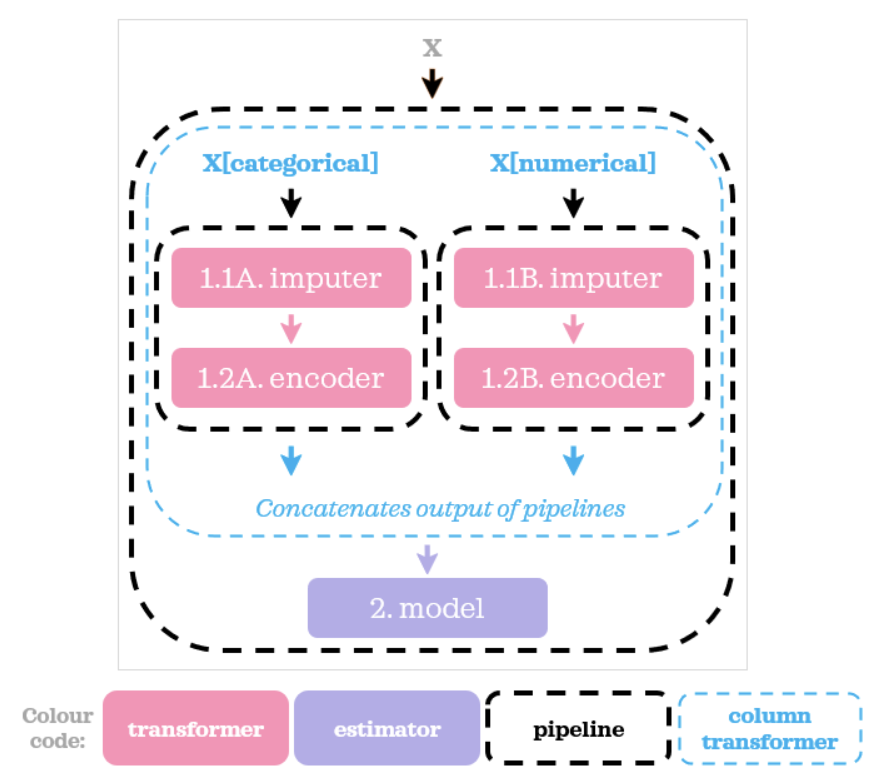


# ColumnTransformer
- bundle together 다른 전처리 단계들
- 즉, 전체 입력 데이터의 다른 하위 집합에 다른 변환기를 적용하고 결과를 다시 연결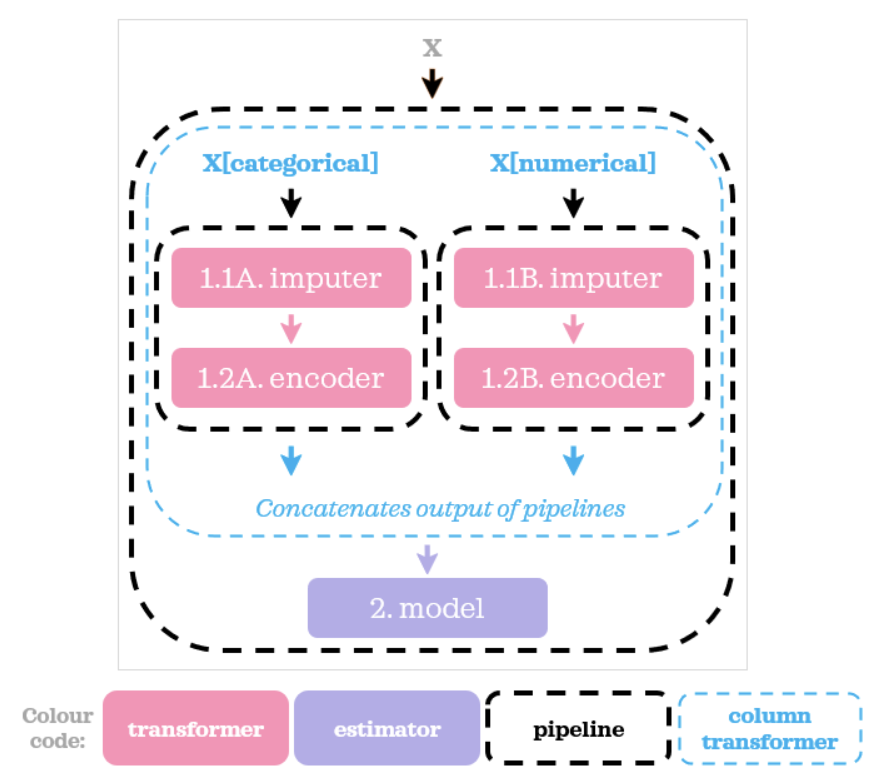




#### 1) SimpleImputer(strategy='constant') : numeric 변수에 대해 특정값 대치
#### 2) SimpleImputer(strategy='most_frequent') : categorical 변수에 대해 최빈값 대치<br>
#### 3) OneHotEncoder(handle_unknown='ignore') : 최빈값 대치 된 categorical 변수를 one-hot encoder 처리



In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data #파이프라인 구축 (categorical 처리)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), #최빈값 대치
    ('onehot', OneHotEncoder(handle_unknown='ignore')) #one hot encoder 처리
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline #파이프라인 구축 (preprocessor + modeling)
clf = Pipeline(steps=[('preprocessor', preprocessor)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
# preds = clf.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 17861.780102739725


# 파이프라인 장점

- 파이프라인을 통해서 전처리된  df를 새로 변수로 할당하지않고 바로모델링까지 해주므로 메모리 및 연산 속도도 개선될 것으로 사료된다.

- clf 를 찍으면 파이프라인에 대한 객체가 들어가있음!!

In [19]:
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBa...
                                                 

In [11]:
X_train.isnull().sum()

MSZoning          0
Street            0
Alley          1097
LotShape          0
LandContour       0
               ... 
ScreenPorch       0
PoolArea          0
MiscVal           0
MoSold            0
YrSold            0
Length: 76, dtype: int64

따라서, 결측치를 다시 찍어보면 전처리되어있지않음!!!

The code yields a value around 17862 for the mean absolute error (MAE).  In the next step, you will amend the code to do better.

# Step 1: Improve the performance

### Part A

Now, it's your turn!  In the code cell below, define your own preprocessing steps and random forest model.  Fill in values for the following variables:
- `numerical_transformer`
- `categorical_transformer`
- `model`

To pass this part of the exercise, you need only define valid preprocessing steps and a random forest model.

In [ ]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant') # Your code here

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
 # Your code here

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0) # Your code here

# Check your answer
step_1.a.check()

In [ ]:
# Lines below will give you a hint or solution code
#step_1.a.hint()
#step_1.a.solution()

### Part B

Run the code cell below without changes.

To pass this step, you need to have defined a pipeline in **Part A** that achieves lower MAE than the code above.  You're encouraged to take your time here and try out many different approaches, to see how low you can get the MAE!  (_If your code does not pass, please amend the preprocessing steps and model in Part A._)

In [ ]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

# Check your answer
step_1.b.check()

In [ ]:
# Line below will give you a hint
#step_1.b.hint()

# Step 2: Generate test predictions

Now, you'll use your trained model to generate predictions with the test data.

In [ ]:
my_pipeline

In [ ]:
# Preprocessing of test data, fit model
preds_test = my_pipeline.predict(X_test) # Your code here

# Check your answer
step_2.check()

In [ ]:
# Lines below will give you a hint or solution code
#step_2.hint()
#step_2.solution()

Run the next code cell without changes to save your results to a CSV file that can be submitted directly to the competition.

In [ ]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

# Submit your results

Once you have successfully completed Step 2, you're ready to submit your results to the leaderboard!  If you choose to do so, make sure that you have already joined the competition by clicking on the **Join Competition** button at [this link](https://www.kaggle.com/c/home-data-for-ml-course).  
1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


# Keep going

Move on to learn about [**cross-validation**](https://www.kaggle.com/alexisbcook/cross-validation), a technique you can use to obtain more accurate estimates of model performance!

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/161289) to chat with other Learners.*